In [ ]:
# Copyright 2019 The TensorFlow Authors.

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Modifications Copyright (C) 2020 Rohan Jagtap

In [4]:
cd /content/drive/My Drive/Colab Notebooks/arc_transformer/

/content/drive/My Drive/Colab Notebooks/arc_transformer


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Loading Data

In [6]:
# Set some parameters
im_width  = 32
im_height = 32

# train_dir="tgs-salt-identification-challenge/competition_data/train"
data_file="data/arc_v6_gsb.npz"

In [7]:
data_dict = np.load(data_file, allow_pickle=True)
data   = data_dict["x_train"] # 32 x 32 grids
labels = data_dict["y_train"] # <task_id>_<dataset>_<example_num>_<inputoutpu> id string
attrs  = data_dict["a_train"] # Metadaa about the task

# print(attrs[:10])
# print(data[2])
# data = data / 255.

data, labels, attrs = shuffle(data, labels, attrs, random_state=0)

# print(data[10])
# data = np.expand_dims(data, -1) # set up array for training

print("No. of grids = ", len(data))
print("Data shape", data.shape)

No. of grids =  6998
Data shape (6998, 32, 32, 3)


#### Data Utiliies

##### Padding Utils

In [8]:
# Pad a ARC Task grid for uniformity
def pad_grid(grid, bound_shape=(32,32)):
    diff = [ bound_shape[i] - grid.shape[i] for i in range(2) ]
    return np.pad(grid, [(0,diff[0]),(0,diff[1])], mode='constant', constant_values=(10,))
    
# Removes padding from a ARC Task grid
def trim_grid(padded_grid):
    bounds = padded_grid == 10
    grid = padded_grid[:np.argmax(np.all(bounds, axis=1)), :np.argmax(np.all(bounds, axis=0))]
    # print(grid.shape)
    return grid

##### Gyroelongated Square Bipyramid

In [9]:
# Represent the 10 colors with a 3D Gyroelongated Square Bipyramid. 
# Coord 0,0,0 is used for padding purposes.
# https://polytope.miraheze.org/wiki/Gyroelongated_square_bipyramid
qurt_8 = np.power(8,1/4)
sqrt_2 = np.power(2,1/2)
# GSB equivalent of the rgbs map
solid  = np.array([
    [0,          0, +(2*sqrt_2 + qurt_8) / 4],
    [0,          0, -(2*sqrt_2 + qurt_8) / 4],
    [+0.5,    +0.5,     qurt_8 / 4],
    [-0.5,    +0.5,     qurt_8 / 4],
    [+0.5,    -0.5,     qurt_8 / 4],
    [-0.5,    -0.5,     qurt_8 / 4],
    [0, +sqrt_2/2, -qurt_8 / 4],
    [0, -sqrt_2/2, -qurt_8 / 4],
    [+sqrt_2/2, 0, -qurt_8 / 4],
    [-sqrt_2/2, 0, -qurt_8 / 4],
    [0,        0,           0]
])

# Retrieve ARC task grid from the GSB representation
gsb_grid_mask = np.tile(solid,(32,32,1,1)) # The result shape is (32, 32, 11, 3)
def gsb_to_grid(gsb_grid):
    g = gsb_grid.copy()
    g = np.expand_dims(g, 2)
    dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
    recovered = np.argmin(dist, axis=2)
    return recovered

def grid_to_gsb(grid):
    new_grid = np.zeros((32,32,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = solid[cell]
    return new_grid

# Tests if two GSB grid is the same
def is_same_grid(a, b):
    result = False
    a_grid = gsb_to_grid(a)
    b_grid = gsb_to_grid(b)
    return np.all(a_grid == b_grid)

##### RGB Color Utils

In [10]:
# RGB colors of the ARC tasks.
# Added #444444 at index 10 for grid padding
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444']
cmap = colors.ListedColormap(rgbs)
norm = colors.Normalize(vmin=0, vmax=10)

# Map #RGB string to 0->1 RGB values
def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

# Map a ARC task grid to a 3 channels RGB ndarray, usable in imshow.
def grid_to_rgb(color_idx):
    # print(color_idx.shape)
    (h, w) = color_idx.shape
    new_grid = np.zeros((h, w, 3))
    for r, row in enumerate(color_idx):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid   

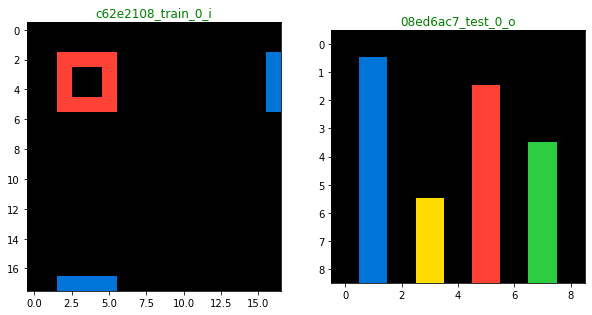

In [11]:
# Visualize any randome image along with the mask
def plot_one(ax, data, label, trim=True):
    grid = gsb_to_grid(data)
    tl_color = 'green' if np.all(grid == grid) else 'red'
    grid = trim_grid(grid) if trim else grid
    ax.imshow(grid_to_rgb(grid))
    ax.set_title(label, color=tl_color)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
# 009d5c81_train_0_o
# ix = random.randint(0, len(X_train))
plot_one(ax1, data[5787], labels[5787])
# a680ac02_test_0_i
# ix = random.randint(0, len(X_train))
plot_one(ax2, data[5837], labels[5837])

#### Start and End Tokens

In [12]:
def token_gen(pattern_str):
    ps = pattern_str.split('|')
    ps_grid = np.array([ list(map(int, list(s))) for s in ps ])
    black = ps_grid == 0
    white = ps_grid == 1
    token_grid = black * 4 + white * 0 # Flip the code to black.
    return pad_grid(token_grid)

Text(0.5, 1.0, 'End')

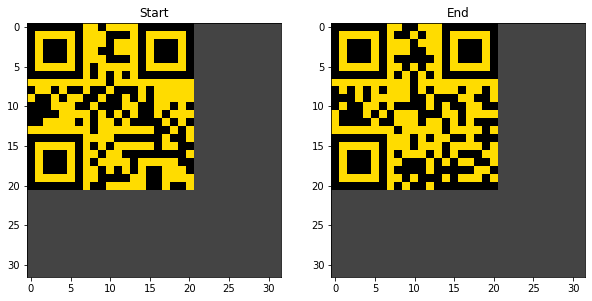

In [13]:
# QR code for "START_TASK" and "END_TASK"
start_task_grid = token_gen(
'111111100100001111111|100000100011101000001|101110100010001011101|101110100110001011101|\
101110100011101011101|100000101000001000001|111111101010101111111|000000000010000000000|\
100101101101110100000|011010011011010100000|111000110111001100101|111100001010101101000|\
110000101001011110101|000000001000000011010|111111100001111110110|100000101010000010011|\
101110100100111111110|101110101000010000011|101110100101010110001|100000100111100110000|111111101100000110110')
end_task_grid   = token_gen(
'111111100110001111111|100000101101001000001|101110100010001011101|101110100011001011101|\
101110101111101011101|100000100101001000001|111111101010101111111|000000000010000000000|\
101010100010100010010|111010000011011100110|101100101111010110011|011101010001110010000|\
011110110001001010111|000000001000001000010|111111100010100110111|100000100010001000010|\
101110101000101011100|101110100111010100110|101110101111011111001|100000100101110100010|111111101011011111111')
stop_token = grid_to_gsb(end_task_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))

ax1.imshow(grid_to_rgb(start_task_grid))
ax1.grid(False)
ax1.set_title("Start")

ax2.imshow(grid_to_rgb(end_task_grid))
ax2.grid(False)
ax2.set_title("End")

### Preprocessing

#### Construct Training Data

In [14]:
# data, labels, attrs, 
# Training data comprises: train_task, test_task

# Constructing the identity task
# train_task_inp - Training task's input, is just a grid and next in sequence is itself.
data_inp = np.stack([data, data], axis=1)
data_inp_labels = labels
data_inp_attrs  = attrs

# train_task_tar - Training task's target, is a random shuffle of the training data.
# NOTE: We can make a lot more variations, it is a n^2 possibility.
shfd_data, shfd_labels, shfd_attrs = shuffle(data, labels, attrs, random_state=0)
# Then add the stop token
all_stop = np.repeat([stop_token], repeats=shfd_data.shape[0], axis=0)
data_tar = np.stack([shfd_data, shfd_data, all_stop], axis=1)
data_tar_labels = shfd_labels
data_tar_attrs  = shfd_attrs

print("Tasks shape", data_inp.shape, data_tar.shape)

Tasks shape (6998, 2, 32, 32, 3) (6998, 3, 32, 32, 3)


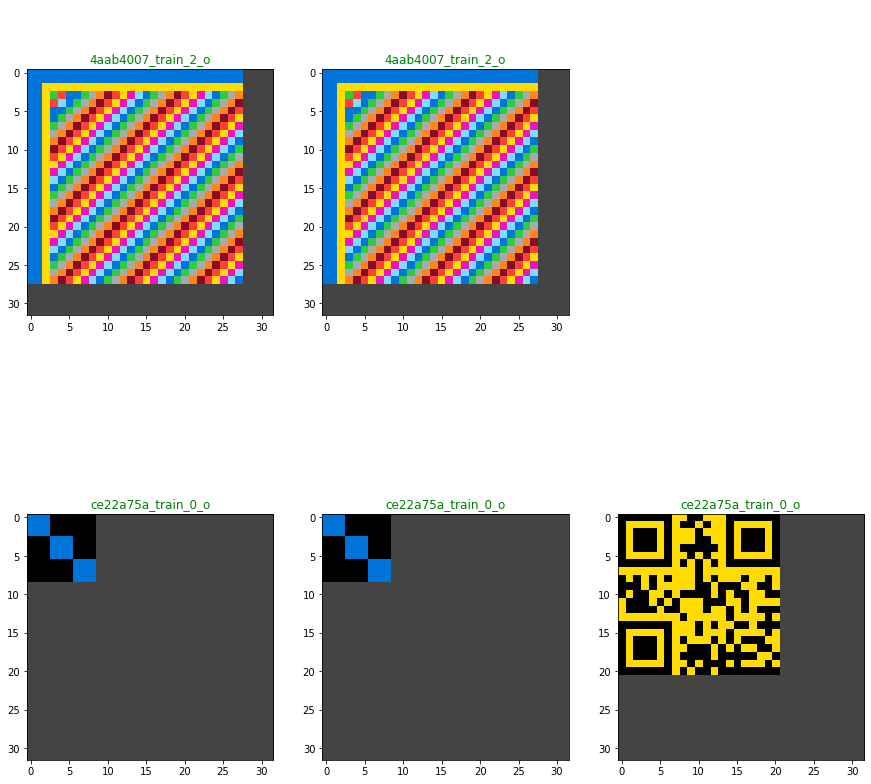

In [15]:
# Take a look at a random task.
task_id = 6345
fig, axes = plt.subplots(2, 3, figsize = (15, 15))
plot_one(axes[0,0], data_inp[task_id][0], data_inp_labels[task_id], trim=False)
plot_one(axes[0,1], data_inp[task_id][1], data_inp_labels[task_id], trim=False)
axes[0,2].axis('off')
plot_one(axes[1,0], data_tar[task_id][0], data_tar_labels[task_id], trim=False)
plot_one(axes[1,1], data_tar[task_id][1], data_tar_labels[task_id], trim=False)
plot_one(axes[1,2], data_tar[task_id][2], data_tar_labels[task_id], trim=False)

#### Split train, test set

In [16]:
# Split train and valid
(train_inp, valid_inp, train_inp_labels, valid_inp_labels, train_inp_attrs, valid_inp_attrs, train_tar, valid_tar, train_tar_labels, valid_tar_labels, train_tar_attrs, valid_tar_attrs) = train_test_split(
    data_inp, data_inp_labels, data_inp_attrs,
    data_tar, data_tar_labels, data_tar_attrs, 
    test_size=0.1, random_state=0)

print("Training", train_inp.shape, train_tar.shape)
print("Validation", valid_inp.shape, valid_tar.shape)

Training (6298, 2, 32, 32, 3) (6298, 3, 32, 32, 3)
Validation (700, 2, 32, 32, 3) (700, 3, 32, 32, 3)


In [17]:
# maxlen - max sequence length
encoder_maxlen = 2
decoder_maxlen = 4
GRID_SHAPE = (32,32,3)

#### Padding/Truncating sequences for identical sequence lengths

In [18]:
zero_grid = np.zeros(GRID_SHAPE)

# zero_grid = np.zeros((4,4,3))
# one_grid  = np.ones((4,4,3))
# mock_train_array = [np.tile(one_grid,(5,1,1,1)), np.tile(one_grid,(3,1,1,1)), np.tile(one_grid,(6,1,1,1))]
# mock_pad = np.array([ np.concatenate((i, np.tile(zero_grid,(max(6-len(i),0),1,1,1))), axis=0) for i in mock_train_array ])
# print(mock_pad.shape)

def standardize_data(data_array, max_seq_length):
    # Create the 0 padded (batch, max_len) representaion of both inputs and targets
    # This is to be used in create_masks.
    data_seq = [ np.ones((len(i)), dtype=np.int32) for i in data_array ]
    data_pad = tf.keras.preprocessing.sequence.pad_sequences(data_seq, maxlen=max_seq_length, padding='post', truncating='post')

    # Create the zero grid padded version (batch, max_len, GRID_SHAPE[0], GRID_SHAPE[1], GRID_SHAPE[2])
    # Thare are the actual inputs.
    std_data = np.array([ np.concatenate((i, np.tile(zero_grid,(max(max_seq_length-len(i),0),1,1,1))), axis=0) for i in data_array ])

    return std_data, data_pad

train_inputs,  train_inputs_pad = standardize_data(train_inp, encoder_maxlen)
train_targets, train_targets_pad = standardize_data(train_tar, decoder_maxlen)
print(train_inputs.shape, train_targets.shape)
print(train_inputs_pad.shape, train_targets_pad.shape)

valid_inputs, valid_inputs_pad = standardize_data(valid_inp, encoder_maxlen)
valid_targets, valid_targets_pad = standardize_data(valid_tar, decoder_maxlen)
print(valid_inputs.shape, valid_targets.shape)
print(valid_inputs_pad.shape, valid_targets_pad.shape)

(6298, 2, 32, 32, 3) (6298, 4, 32, 32, 3)
(6298, 2) (6298, 4)
(700, 2, 32, 32, 3) (700, 4, 32, 32, 3)
(700, 2) (700, 4)


#### Creating dataset pipeline

In [19]:
# inputs = tf.cast(inputs, dtype=tf.int32)
# targets = tf.cast(targets, dtype=tf.int32)
# inputs = train_inp
# targets = train_tar

In [20]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [21]:
training_set = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets, train_inputs_pad, train_targets_pad)).shuffle(BUFFER_SIZE, seed=0).batch(BATCH_SIZE)
validatn_set = (valid_inputs, valid_targets, valid_inputs_pad, valid_targets_pad)

### Building the Model

#### Positional Encoding for adding notion of position among words as unlike RNN this is non-directional

In [22]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [23]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


#### Masking

- Padding mask for masking "pad" sequences
- Lookahead mask for masking future words from contributing in prediction of current words in self attention
- The mask operation is achieved by adding a large negative number, thus the mask convention 0 for content element, 1 is to be masked.

In [24]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [25]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

#### Scaled Dot Product

In [26]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-Headed Attention

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

#### Feed Forward Network

In [28]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### Embedding

In [29]:
class EmbeddingLayer(tf.keras.layers.Layer):
    # say seq_len = 4,
    # Then each should go through the same embedding weights, 
    # yield dimention d_model
    #
    # So:
    # Input  (batch_size, seq_len, 32, 32, 3)
    # Output (batch_size, seq_len, d_model) 
    #
    def __init__(self, in_shape, d_model):
        super(EmbeddingLayer, self).__init__()

        # Simplest Encoder is just a Dense layer
        self.encoder = tf.keras.models.Sequential()
        self.encoder.add(tf.keras.layers.InputLayer(in_shape,))
        self.encoder.add(tf.keras.layers.Flatten())
        self.encoder.add(tf.keras.layers.Dense(d_model)) 
        
    def call(self, x, training):
        # Apply the same encoder to each element in the sequence 
        seq = tf.unstack(x, axis=1)
        emb = [ self.encoder( s ) for s in seq ] 
        output = tf.stack(emb, axis=1)

        return output

#### Fundamental Unit of Transformer encoder

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


#### Fundamental Unit of Transformer decoder

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


#### Encoder consisting of multiple EncoderLayer(s)

In [32]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, embedding_layer, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embedding_layer # tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x


#### Decoder consisting of multiple DecoderLayer(s)

In [33]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, embedding_layer, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embedding_layer # tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


#### Finally, the Transformer

In [34]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, pe_input, pe_target, embedding_layer, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, pe_input, embedding_layer, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, pe_target, embedding_layer, rate)

        self.final_layer = tf.keras.models.Sequential()
        self.final_layer.add( tf.keras.layers.Dense(np.prod(GRID_SHAPE)) )
        self.final_layer.add( tf.keras.layers.Reshape((-1, GRID_SHAPE[0], GRID_SHAPE[1], GRID_SHAPE[2])) ) # <- what's the right param?
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


### Training

In [78]:
# hyper-params
num_layers = 1
d_model = 2048 # 128
dff = 512
num_heads = 4 # 8 
EPOCHS = 60

#### Adam optimizer with custom learning rate scheduling

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model # was 128, now 2048
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        print("Step", step.nump())
        arg1 = tf.math.rsqrt(step) # would have been 858 batches. 1, 0.707, 0.577.... 1/sqrt(858) = 0.0341394371
        arg2 = step * (self.warmup_steps ** -1.5) # step & (4000 ** -1.5) = 0.000003952847075 * 0.0341394371 = 0.000000134947974

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [85]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05) # tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9) 
# Defauls, for reference:
#    learning_rate=0.001,
#    beta_1=0.9,
#    beta_2=0.999,
#    epsilon=1e-07,

#### Defining losses and other metrics 

In [38]:
loss_object = tf.keras.losses.MeanSquaredError() # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [39]:
def loss_function(real, pred):
    # mask = tf.math.logical_not(tf.math.equal(real, 0)) # 0->True->False, >0->False->True
    loss_ = loss_object(real, pred)

    # mask = tf.cast(mask, dtype=loss_.dtype) # masked 0, 1 for non-zeros
    # loss_ *= mask # only care about where real was non-zero.

    # return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    return loss_

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

#### Transformer

In [57]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_maxlen, 
    decoder_maxlen,
    EmbeddingLayer( GRID_SHAPE, d_model),
)

#### Masks

In [42]:
def create_masks(inp, tar):
    
    # By the time we got here, inp and tar are already 0 padded.
    # With text inputs, we just need to create the masks from that accordingly.
    # But for this use case, given our inputs are 3D grids, for this function we need 
    # a representation of inp (encoder input) and tar (decoder inputs) without the grids.
    # i.e. we need them to be in the form (batch_size, sequence_len)
    
    # print("create mask",inp.shape, tar.shape)
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask


#### Checkpoints

In [86]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [59]:
# inp = tf.keras.Input((encoder_maxlen,1), name='text')
# print(inp.shape)
# stransformer.compile()
# transformer.summary()

#### Training steps

In [60]:
@tf.function
def train_step(inp, tar, inp_pad, tar_pad):
    tar_inp = tar[:, :-1] # without stop
    tar_real = tar[:, 1:] # without go or the first element.

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_pad, tar_pad[:, :-1])

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [87]:
history = []
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar, inp_pad, tar_pad)) in enumerate(training_set):
        train_step(inp, tar, inp_pad, tar_pad)
    
        # 6.3k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 6.3k / 64 ~ 100; 100 / 5 = 20
        if batch % 20 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    history.append(train_loss.result())

Epoch 1 Batch 0 Loss 0.0118
Epoch 1 Batch 20 Loss 0.0101
Epoch 1 Batch 40 Loss 0.0099
Epoch 1 Batch 60 Loss 0.0097
Epoch 1 Batch 80 Loss 0.0099
Epoch 1 Loss 0.0103
Time taken for 1 epoch: 3.0069632530212402 secs

Epoch 2 Batch 0 Loss 0.0078
Epoch 2 Batch 20 Loss 0.0109
Epoch 2 Batch 40 Loss 0.0103
Epoch 2 Batch 60 Loss 0.0102
Epoch 2 Batch 80 Loss 0.0102
Epoch 2 Loss 0.0102
Time taken for 1 epoch: 2.941483736038208 secs

Epoch 3 Batch 0 Loss 0.0116
Epoch 3 Batch 20 Loss 0.0096
Epoch 3 Batch 40 Loss 0.0096
Epoch 3 Batch 60 Loss 0.0096
Epoch 3 Batch 80 Loss 0.0098
Epoch 3 Loss 0.0099
Time taken for 1 epoch: 2.944302797317505 secs

Epoch 4 Batch 0 Loss 0.0072
Epoch 4 Batch 20 Loss 0.0106
Epoch 4 Batch 40 Loss 0.0104
Epoch 4 Batch 60 Loss 0.0105
Epoch 4 Batch 80 Loss 0.0105
Epoch 4 Loss 0.0106
Time taken for 1 epoch: 2.9561140537261963 secs

Epoch 5 Batch 0 Loss 0.0112
Epoch 5 Batch 20 Loss 0.0098
Epoch 5 Batch 40 Loss 0.0101
Epoch 5 Batch 60 Loss 0.0101
Epoch 5 Batch 80 Loss 0.0101
Saving

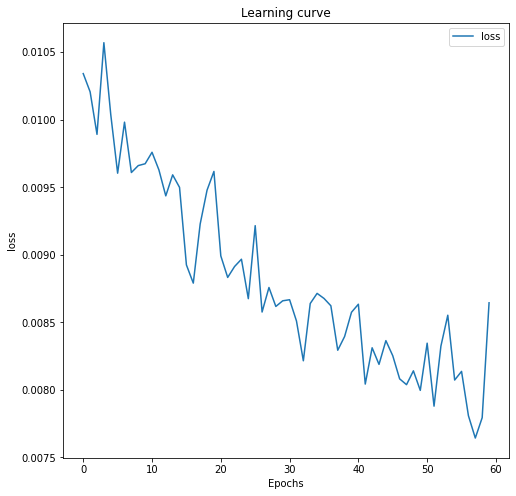

In [88]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history, label="loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();
# transformer.summary()

### Inference

In [73]:
# Predicting one token at a time at the decoder and appending it to the output; 
# then taking the complete sequence as an input to the decoder,
# repeating until maxlen or stop keyword appears
def predict(inp, tar_head, inp_pad, tar_pad):

    encoder_input = inp
    output        = tar_head
    output_pad    = tar_pad
    stop_detected = False
    
    # maxlen = decoder_maxlen # tar_len if tar_len else decoder_maxlen
    for i in range(decoder_maxlen-1):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_pad, output_pad)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )        
        latest = np.array(predictions[-1,-1])
        if not stop_detected:
            stop_detected = np.all(np.equal(gsb_to_grid(latest), end_task_grid)) 
        latest_append = np.array(np.expand_dims(latest, axis=(0,1)))
        output     = np.concatenate([output, latest_append], axis=1)
        output_pad = np.concatenate([output_pad, np.ones((1,1))], axis=1)
    
    return tf.squeeze(output, axis=0), stop_detected # attention_weights


In [64]:
def solve_one(inp, tar, inp_pad, tar_pad):
    inp_ = np.expand_dims(inp, axis=0)
    tar_ = np.expand_dims(tar[0], axis=(0,1))
    inp_pad_ = np.expand_dims(inp_pad, axis=0)
    tar_pad_ = np.expand_dims(tar_pad[0], axis=(0,1))
    pred, stop_detected = predict( inp_, tar_, inp_pad_, tar_pad_)
    loss = loss_function(tar, pred).numpy()
    return pred, loss, stop_detected

In [65]:
# Plot task grids
def plot_task( inp, tar, pred, idx ):
    fig, axes = plt.subplots(1, len(inp[idx]), figsize = (7, 20))
    for i in range(len(inp[idx])):
        plot_one(axes[i], np.array(inp[idx][i]), "", trim=False) 
    fig, axes = plt.subplots(1, len(tar[idx]), figsize = (15, 20))
    for i in range(len(tar[idx])):
        plot_one(axes[i], np.array(tar[idx][i]), "", trim=False)
    fig, axes = plt.subplots(1, len(pred), figsize = (15, 20))
    for i in range(len(pred)):
        plot_one(axes[i], np.array(pred[i]), "", trim=False)

In [66]:
def solve_and_plot(from_dataset, inp_labels, target_labels, idxs=None):

    (inp, tar, inp_pad, tar_pad) = from_dataset
    if not idxs:
        # Pick a random one        
        idxs = [np.random.randint(0, len(inp))]
        
    for idx in idxs:
        print("Task index: {}, Input: {}, Target: {}".format(idx, inp_labels[idx], target_labels[idx]))
        # Run prediction
        pred, loss, stop_detected = solve_one(inp[idx], tar[idx], inp_pad[idx], tar_pad[idx])
        print("Result Elements: {}, Shape: {}, Stopped: {}".format(len(pred), pred.shape, stop_detected))
        print("Loss", loss)
        plot_task( inp, tar, pred, idx )
        

#### Try from Training Set

Task index: 58, Input: be03b35f_train_0_i, Target: e509e548_train_2_o
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: False
Loss 0.03723304586588195


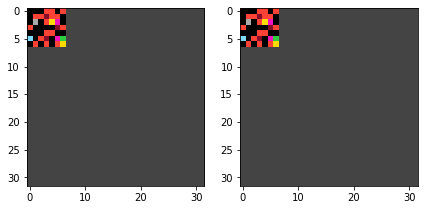

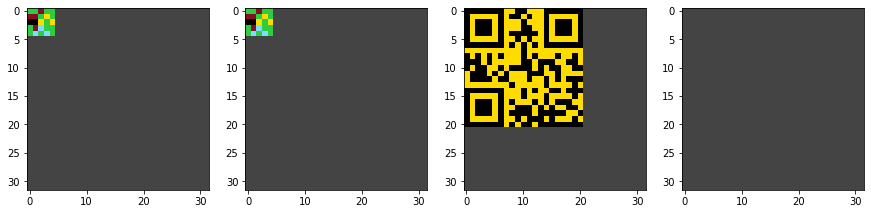

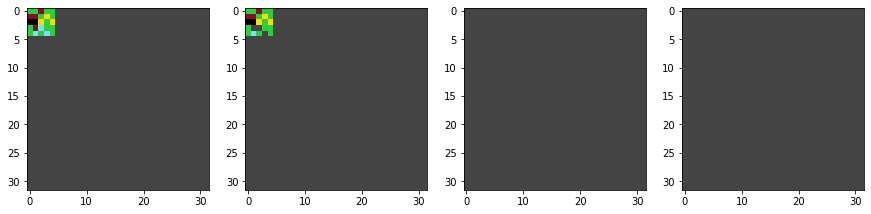

In [89]:
tset = list(training_set.as_numpy_iterator())
solve_and_plot(tset[0], train_inp_labels, train_tar_labels)

#### Try from Test Set

Task index: 576, Input: 817e6c09_train_1_o, Target: ca8f78db_train_0_i
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: False
Loss 0.06380896202355782


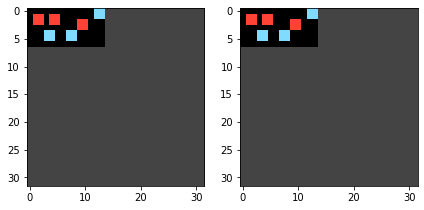

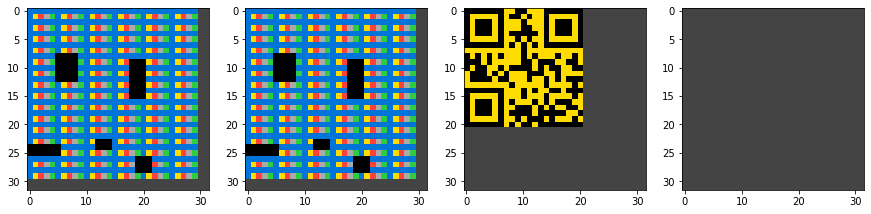

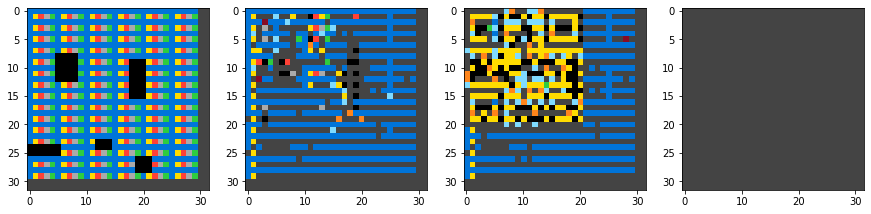

In [90]:
solve_and_plot(validatn_set, valid_inp_labels, valid_tar_labels)

Task index: 107, Input: 92e50de0_train_1_o, Target: 7d18a6fb_test_0_i
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: False
Loss 0.04916957480343838
Task index: 420, Input: d4469b4b_train_0_o, Target: d931c21c_train_3_i
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: False
Loss 0.05745327750365258
Task index: 326, Input: fc754716_train_0_o, Target: 0e206a2e_test_0_o
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: False
Loss 0.05132857782809372
Task index: 416, Input: 50f325b5_train_0_o, Target: 9172f3a0_train_1_o
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: True
Loss 0.001360313434552229
Task index: 535, Input: d06dbe63_test_0_i, Target: d23f8c26_test_0_i
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: False
Loss 0.030187139258865743
Task index: 471, Input: 253bf280_train_4_i, Target: 4f537728_test_0_o
Result Elements: 4, Shape: (4, 32, 32, 3), Stopped: False
Loss 0.051647156337960694


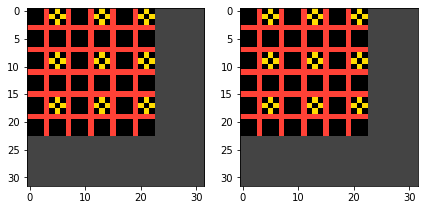

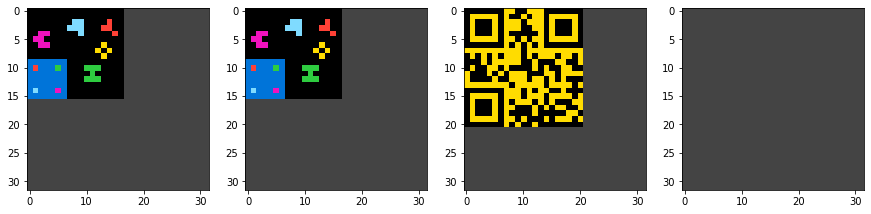

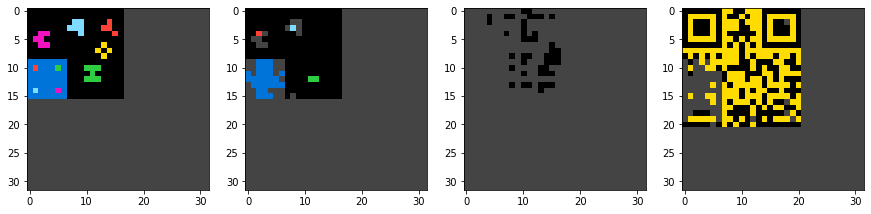

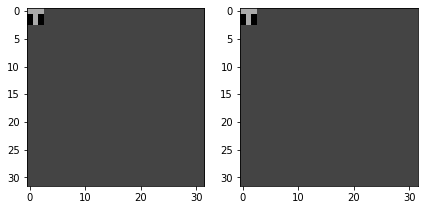

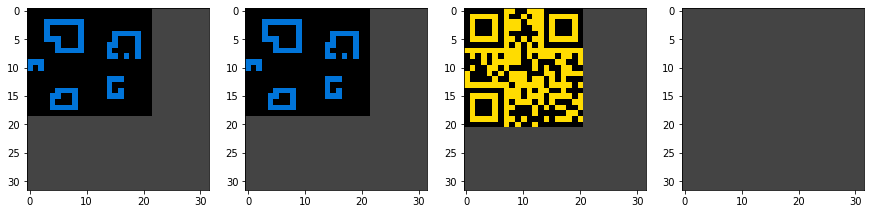

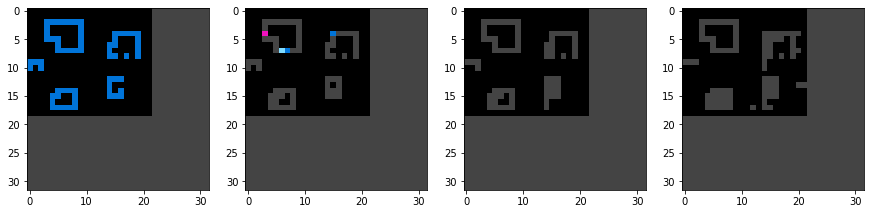

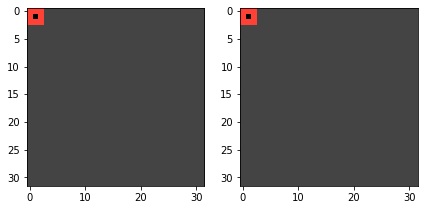

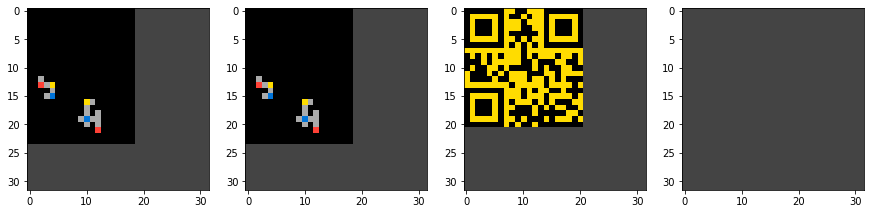

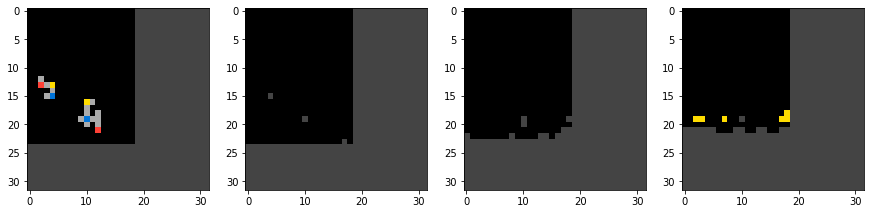

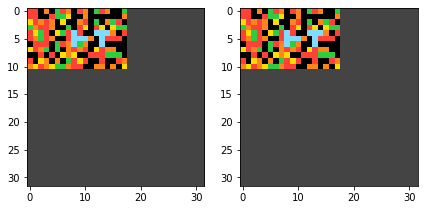

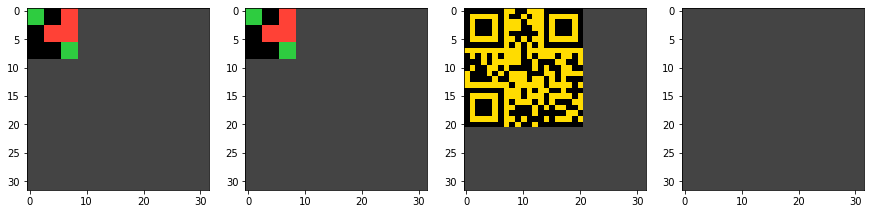

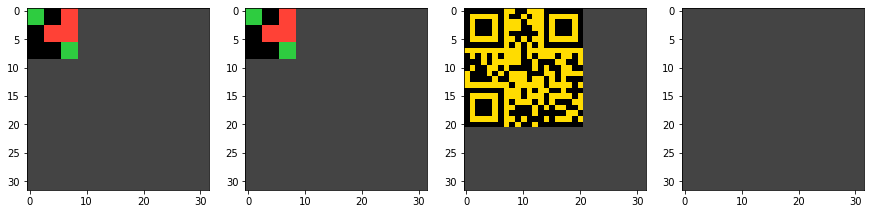

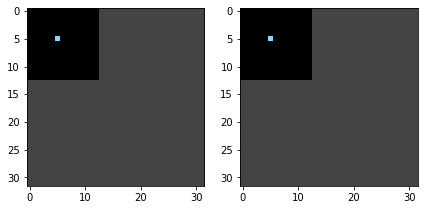

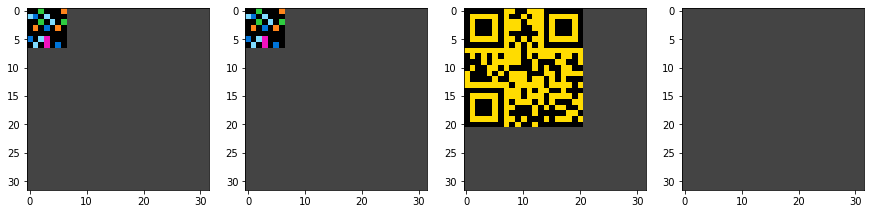

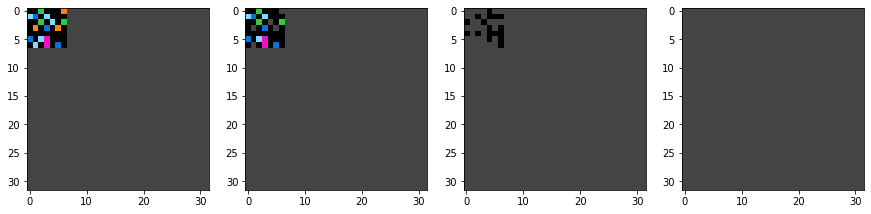

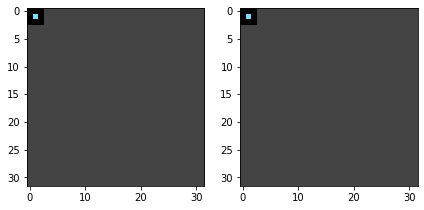

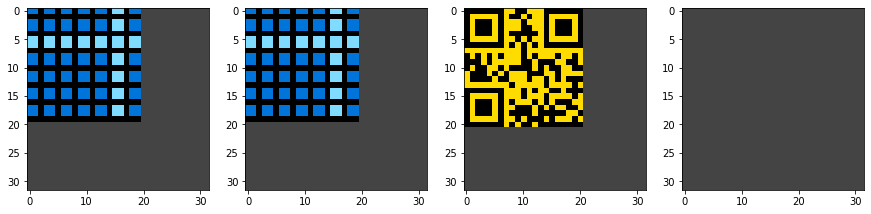

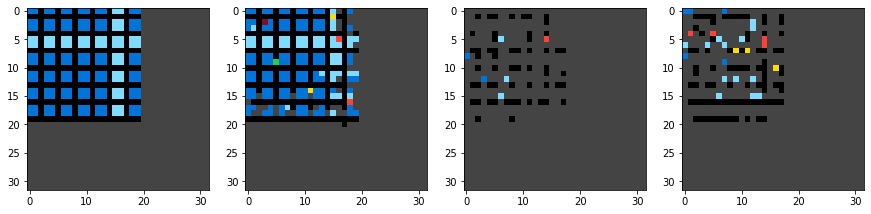

In [91]:
solve_and_plot(validatn_set, valid_inp_labels, valid_tar_labels, [107, 420, 326, 416, 535, 471])

#### Score Test Set

In [92]:
total_loss=0
stops_found=0

(inp, tar, inp_pad, tar_pad) = validatn_set
for idx in range(len(inp)):
    pred, loss, stop_detected = solve_one(inp[idx], tar[idx], inp_pad[idx], tar_pad[idx])
    total_loss += loss
    stops_found+= stop_detected
    
print("Count: {}, Avg loss: {}, Stops found: {}".format(len(inp), total_loss/len(inp), stops_found))

Count: 700, Avg loss: 0.028173723944855702, Stops found: 267
